# Session 4: Neighborhood Enrichment Analysis

In [1]:
import scanpy as sc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In contrast to normal single cell RNA-seq analysis, spatial transcriptomics provides additional information for the location of cells. 
While in the last sessions we mainly focused on the expression information, in this tutorial we want to analyze the actual spatial location of cells in the tissue. We will do this using neighborhood enrichment analysis.

Therefore we'll use the [<img src="https://squidpy.readthedocs.io/en/stable/_static/squidpy_horizontal.png" width="120" height="40">](https://squidpy.readthedocs.io/en/stable/) library for the analysis of spatial transcriptomics data sets.

In [2]:
import squidpy as sq

Squidpy is build on top of scanpy, thus we can read in the data from the previous session as before

In [3]:
adata = sc.read("lymph_node_clustered.h5ad")

## Visualizations

Also in the previous session, we visualized the detected cell type clusters using `sc.pl.spatial`, but squidy offers a more advanced functionality with the [sq.pl.spatial_scatter](https://squidpy.readthedocs.io/en/latest/api/squidpy.pl.spatial_scatter.html) function.

We can create the same visualization as with `sc.pl.spatial`:

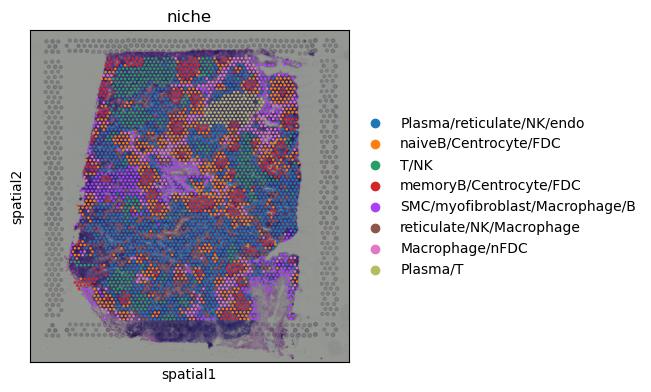

In [4]:
    sq.pl.spatial_scatter(
        adata,
        color="niche",
    )

... but we can also for example remove the background image to just show the location of cell types a bit clearer.

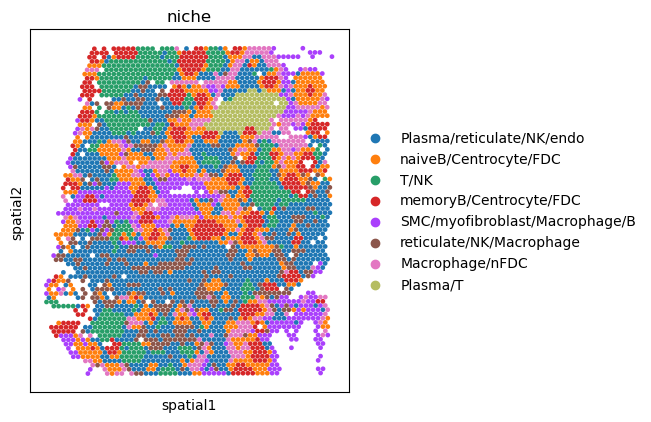

In [5]:
    sq.pl.spatial_scatter(
        adata,
        color="niche",
        img=False, size=1.5
    )

Now try it yourself, and see if you can zoom into a specific region of the tissue. 
Hint: A complete reference on the `sq.pl.spatial_scatter` can be found [here](https://squidpy.readthedocs.io/en/latest/api/squidpy.pl.spatial_scatter.html).

## Neighborhood enrichment

As seen in the image above, some clusters seem to be located in distinct regions. We'll investigate this more quantitatively using 
neighborhood enrichment test implemented in [sq.gr.nhood_enrichment()](https://squidpy.readthedocs.io/en/latest/api/squidpy.gr.nhood_enrichment.html).

This determines if two clusters are on average closer to each other than expected.  For computing how close two clusters are, the spatial information is absolutely necessary.

To use this test, we first have to compute the distances between spots in the tissue. This can be done using the [sq.gr.spatial_neighbors()](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.spatial_neighbors.html) function.

This function will compute a graph, which consists of spots (nodes) and spot-spot interactions (edges).

In [6]:
sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial")

This network (or parts of it) can be visualized. Unfortunatly, there is no available function for it, so we'll use the [networkx (nx)](https://networkx.org/documentation/stable/index.html) library.

In the code below we'll visualize the interactions of the first 100 spots.

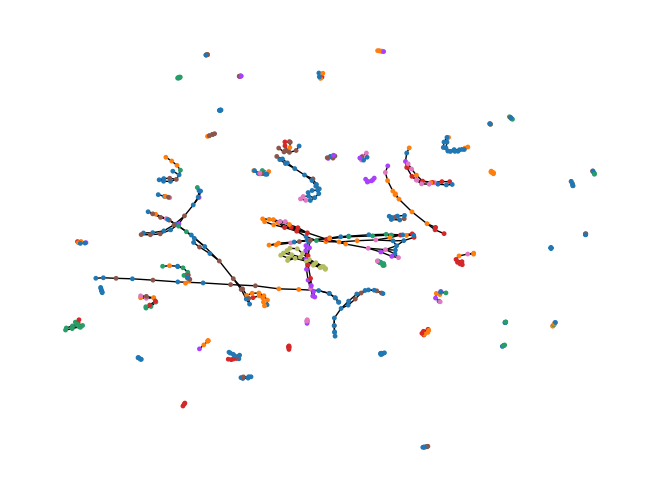

In [7]:
adjacency = adata.obsp["spatial_distances"].toarray()
idx = adjacency[0:100].sum(axis=0) > 0
colors = adata.obs.niche.map(dict(zip(adata.obs.niche.cat.categories, adata.uns["niche_colors"])))
adjacency = adata.obsp["spatial_distances"].toarray()[idx,:][:, idx]
graph =  nx.from_numpy_array(adjacency, )
nx.draw(graph, node_size=6,node_color=colors[idx])

Can you explain what you're seeing ?  Why are most spots only connected to a few other spots ? 
Where do these long line-shaped connections come from ?  

Now we can use the spatial distances to perform the neighborhood enrichment test:

In [8]:
sq.gr.nhood_enrichment(adata, cluster_key="niche")

  0%|          | 0/1000 [00:00<?, ?/s]

This can be visualized using a heatmap. Here x- and y-axis represent the cell types (clusters) and the color how often these cell types are found next to each other.  

Which clusters do you think are more often neihbors?

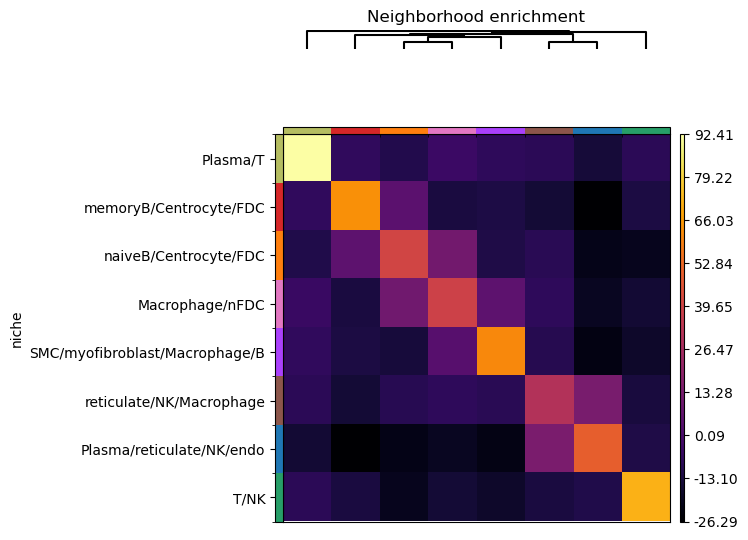

In [9]:
sq.pl.nhood_enrichment(
    adata,
    cluster_key="niche",
    method="average",
    mode="zscore",
    cmap="inferno",
)

Here mainly follicular dendritic cells (FDC) containing cell clusters and Macrophage containing clusters are located together. 
Especially, if clusters contain multiple cell types, as here, often these clusters are also located next to each other.  

### Spatial Co-Occurrence 

Another way of investigating the spatial location of cell type clusters is the concept of co-occurence. 
Here the change of occurence of cells from a specific cluster is investigated at varying distances. 
This change, estimated as co-occurence probability, can be compared to the expected probability, to investigate unexpected changes.
We'll use the [sq.gr.co_occurrence](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.co_occurrence.html) function to compute the change in co-occurence probability.

In [10]:
sq.gr.co_occurrence(adata, cluster_key="niche")


  0%|          | 0/1 [00:00<?, ?/s]

This can be visualized using the [sq.pl.co_occurrence](https://squidpy.readthedocs.io/en/stable/api/squidpy.pl.co_occurrence.html), but we will make cahnges for better visibility.

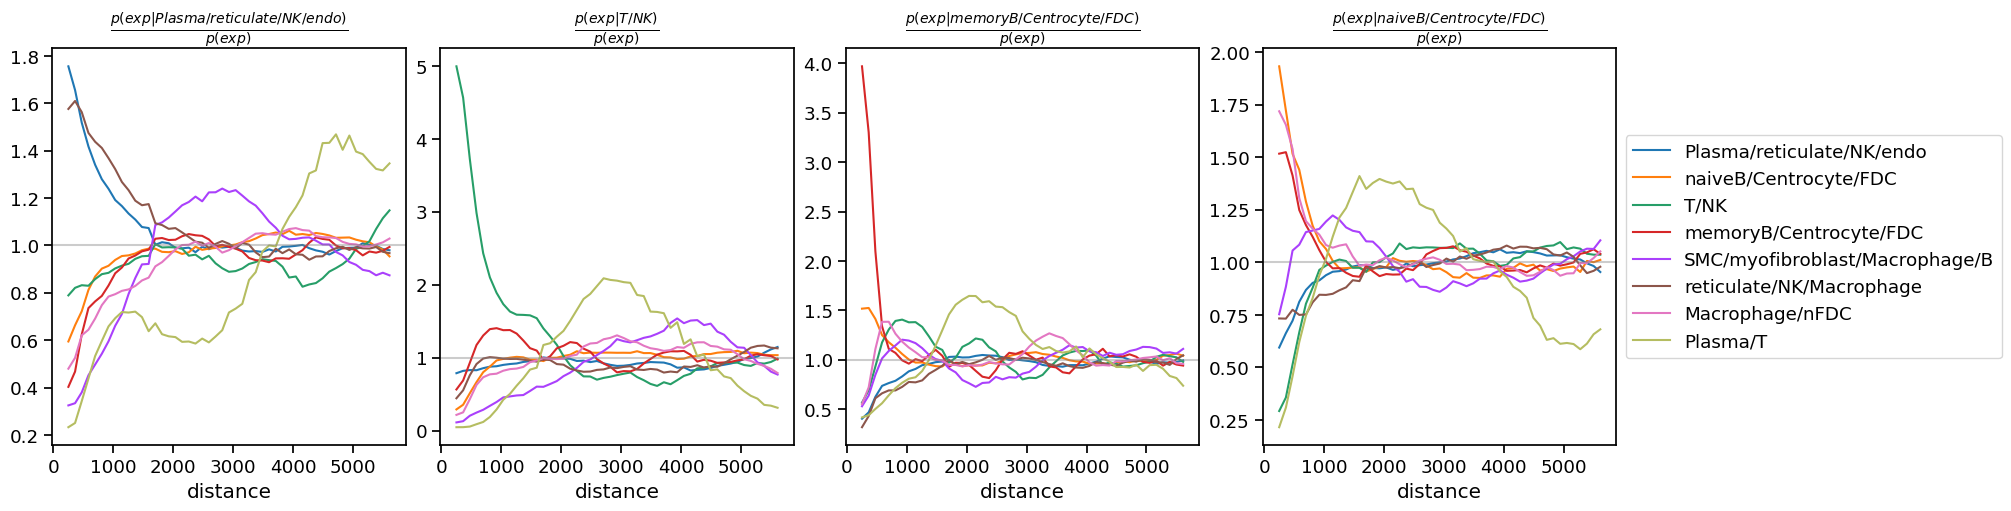

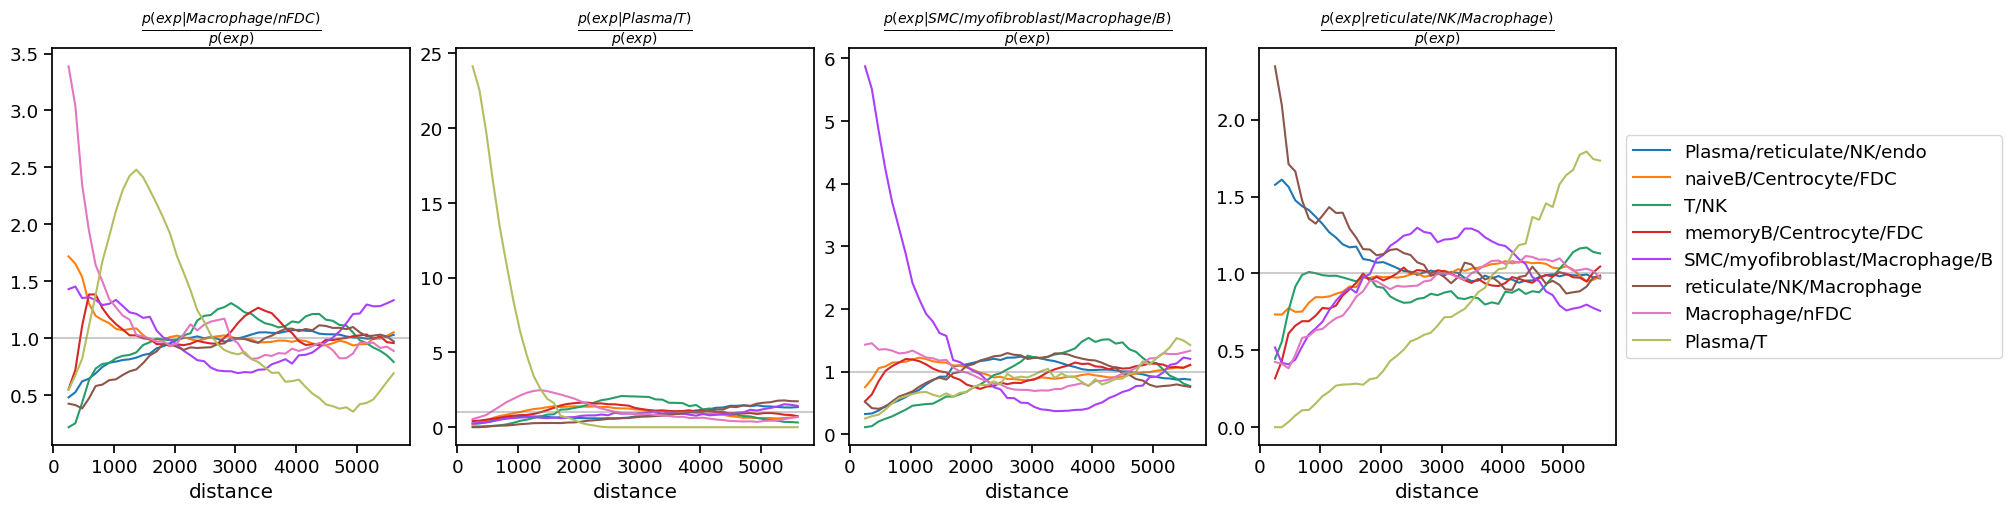

In [11]:
sns.set_context("notebook", font_scale=1.2)
for i in range(0, len(adata.obs.niche.cat.categories), 4):
    sq.pl.co_occurrence(
        adata,
        cluster_key="niche",
        clusters=adata.obs.niche.cat.categories[i:i+4],
    )
    axes = plt.gcf().get_axes()
    for j in range(len(axes)-1):
        axes[j].get_legend().remove()
    for ax in axes:
        ax.axhline(1, c="gray", alpha=0.4)
        ax.set_ylabel("")
sns.set_context("notebook")

Here, the x-axis shows the distances between cells and the y-axis the ratio of real vs expected probability of co-occurence of two clusters. 

The reference cluster is shown in the plot title while the other clusters are shown as colored lines. 

Can you explain why the "Plasma/T" cluster shows such strong differences?

### Network Centrality

In addition to these two metrics for eighborhood enrichment analysis, we can also use graph-based centrality scores. These include

* closeness centrality: how close a cluster is to other spots
* degree centrality: fraction of connected non-group members
* clustering coefficient: measure clustering degree 

and can be computed using [sq.gr.centrality_scores](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.centrality_scores.html).

In [12]:
sq.gr.centrality_scores(adata, "niche")

We'll plot the top two clusters of the `average_clustering` score using the  [sq.pl.spatial_scatter](https://squidpy.readthedocs.io/en/latest/api/squidpy.pl.spatial_scatter.html) function.

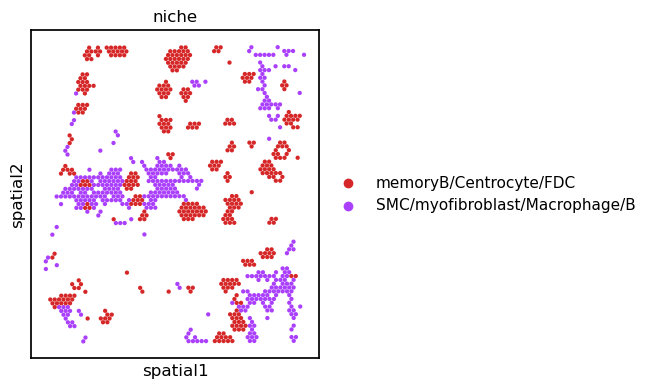

In [13]:
sq.pl.spatial_scatter(
    adata,
    color="niche",
    img=False, size=1.5,
    groups=adata.uns["niche_centrality_scores"]["average_clustering"].sort_values(ascending=False).head(2).index,
)

You can see that which this approach, we're able to identify clusters which show strong clustering into local groups. 

Can you try plotting the "degree centrality" and "closeness centrality", how do they differ ? 

Great, we performed:
* Neighborhood enrichment
* Spatial co-occurrence
* Network centrality